<a href="https://colab.research.google.com/github/Grupo242022/AN_Supervisado_2022/blob/main/Pr%C3%A1ctico_NoSupervisado_fifa2022_G24.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1.-Inicialización-del-entorno

**Empezamos cargando algunas herramientas para cargar los datos y manipularlos.**

In [1]:
!pip install mglearn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns',100)
pd.set_option('display.max_rows',1000)
import itertools
import warnings
warnings.filterwarnings("ignore")
import io

import mglearn

from sklearn.cluster import KMeans
from sklearn.preprocessing  import scale

**Para visualización usaremos principalmente plotly, también seaborn y matplotlib.**

In [3]:
from plotly.offline import init_notebook_mode, plot,iplot
import plotly.graph_objs as go
init_notebook_mode(connected=True)
import matplotlib.pyplot as plt
import plotly.tools as tls#visualization
import plotly.figure_factory as ff#visualization
import seaborn as sns


## 2.- Limpieza y Exploración de la base de datos FIFA 22

**Cargamos los datos bajados de la database de [Kaggle](https://www.kaggle.com/karangadiya/fifa22). [Enlace](https://www.kaggle.com/datasets/stefanoleone992/fifa-22-complete-player-dataset)  como 'data.csv'.** 

In [4]:
url='https://github.com/Grupo242022/AN_Supervisado_2022/blob/main/players_22.csv?raw=true'
df=pd.read_csv(url, sep=',')



- Damos una mirada rápida al conjunto de datos:

In [5]:
df = pd.read_csv(url)
df.tail(3)

,sofifa_id,player_url,short_name,long_name,player_positions,overall,potential,value_eur,wage_eur,age,dob,height_cm,weight_kg,club_team_id,club_name,league_name,league_level,club_position,club_jersey_number,club_loaned_from,club_joined,club_contract_valid_until,nationality_id,nationality_name,nation_team_id,nation_position,nation_jersey_number,preferred_foot,weak_foot,skill_moves,international_reputation,work_rate,body_type,real_face,release_clause_eur,player_tags,player_traits,pace,shooting,passing,dribbling,defending,physic,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,attacking_volleys,skill_dribbling,skill_curve,...,power_stamina,power_strength,power_long_shots,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_marking_awareness,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes,goalkeeping_speed,ls,st,rs,lw,lf,cf,rf,rw,lam,cam,ram,lm,lcm,cm,rcm,rm,lwb,ldm,cdm,rdm,rwb,lb,lcb,cb,rcb,rb,gk,player_face_url,club_logo_url,club_flag_url,nation_logo_url,nation_flag_url
19236,262760,https://sofifa.com/player/262760/nathan-logue/...,N. Logue,Nathan Logue-Cunningham,CM,47,55,100000.0,500.0,21,2000-02-07,178,72,111131.0,Finn Harps,Rep. Ireland Airtricity League,1.0,RES,31.0,NaN,2021-06-18,2021.0,25,Republic of Ireland,NaN,NaN,NaN,Right,3,2,1,Medium/Medium,Lean (170-185),No,175000.0,NaN,NaN,60.0,37.0,45.0,49.0,41.0,52.0,39,32,43,49,37,47,37,...,56,50,34,51,38,45,46,39,36,38,44,48,8,6,7,10,6,NaN,45+2,45+2,45+2,46,46,46,46,46,47+2,47+2,47+2,48+2,47+2,47+2,47+2,48+2,47+2,46+2,46+2,46+2,47+2,47+2,45+2,45+2,45+2,47+2,12+2,https://cdn.sofifa.net/players/262/760/22_120.png,https://cdn.sofifa.net/teams/111131/60.png,https://cdn.sofifa.net/flags/ie.png,NaN,https://cdn.sofifa.net/flags/ie.png
19237,262820,https://sofifa.com/player/262820/luke-rudden/2...,L. Rudden,Luke Rudden,ST,47,60,110000.0,500.0,19,2002-04-23,173,66,111131.0,Finn Harps,Rep. Ireland Airtricity League,1.0,RES,12.0,NaN,2021-06-18,2021.0,25,Republic of Ireland,NaN,NaN,NaN,Right,3,2,1,Medium/Medium,Lean (170-185),No,239000.0,NaN,NaN,68.0,46.0,36.0,48.0,15.0,42.0,29,49,40,38,34,42,36,...,50,40,41,34,14,47,40,49,47,10,14,11,7,10,7,14,15,NaN,47+2,47+2,47+2,47,47,47,47,47,45+2,45+2,45+2,45+2,39+2,39+2,39+2,45+2,33+2,29+2,29+2,29+2,33+2,32+2,26+2,26+2,26+2,32+2,15+2,https://cdn.sofifa.net/players/262/820/22_120.png,https://cdn.sofifa.net/teams/111131/60.png,https://cdn.sofifa.net/flags/ie.png,NaN,https://cdn.sofifa.net/flags/ie.png
19238,264540,https://sofifa.com/player/264540/emanuel-lalch...,E. Lalchhanchhuaha,Emanuel Lalchhanchhuaha,CAM,47,60,110000.0,500.0,19,2002-02-06,167,61,113040.0,NorthEast United FC,Indian Super League,1.0,SUB,13.0,NaN,2021-08-31,2025.0,159,India,NaN,NaN,NaN,Right,3,2,1,Medium/Medium,Lean (170-),No,217000.0,NaN,NaN,68.0,38.0,45.0,48.0,36.0,48.0,39,32,46,50,37,48,38,...,57,40,36,55,42,47,46,35,36,33,31,37,8,13,13,9,14,NaN,45+2,45+2,45+2,47,47,47,47,47,47+2,47+2,47+2,48+2,46+2,46+2,46+2,48+2,45+2,44+2,44+2,44+2,45+2,45+2,41+2,41+2,41+2,45+2,16+2,https://cdn.sofifa.net/players/264/540/22_120.png,https://cdn.sofifa.net/teams/113040/60.png,https://cdn.sofifa.net/flags/in.png,NaN,https://cdn.sofifa.net/flags/in.png


- Determinamos el numero de filas y columnas del conjunto de dato. A su vez tomamos de muestra la columna de posicion de jugador y observamos su contenido... 


In [6]:
print(df.columns)
print(len(df.columns), 'variables') # 110 variables

Index(['sofifa_id', 'player_url', 'short_name', 'long_name',
       'player_positions', 'overall', 'potential', 'value_eur', 'wage_eur',
       'age',
       ...
       'lcb', 'cb', 'rcb', 'rb', 'gk', 'player_face_url', 'club_logo_url',
       'club_flag_url', 'nation_logo_url', 'nation_flag_url'],
      dtype='object', length=110)
110 variables


In [7]:
df.player_positions.loc[:10,]

0     RW, ST, CF
1             ST
2         ST, LW
3        LW, CAM
4        CM, CAM
5             GK
6         ST, LW
7             GK
8             GK
9             ST
10       CDM, CM
Name: player_positions, dtype: object

 - Análisis exploratorio:

 Basandonos en el codigo de [Unal Koroglu - Kaggle](https://www.kaggle.com/code/nalkrolu/fifa-19-complete-player-dataset-analysis), visualizaremos el comportamiento de la base de datos / tipo de jugadores:

In [8]:
# Tipo de jugador - atributos dentro de la variable posicion de jugador:
DEFENDING = ["CB","LB","LCB","LWB","RB","RCB","RWB"]
MIDFIELD = ["CAM","CDM","CM","LAM","LCM","LDM","LM","RAM","RCM","RDM","RM"]
ATTACKING = ["CF","LF","RF","RS","RW","LW","LS","ST"]
GOALKEEPER = ["GK"]

# almacenando estos en un listado
main = []

for i in df["player_positions"]:
    if set(i.split(',')).intersection(DEFENDING):
        main.append("Defensa")
        
    elif set(i.split(',')).intersection(MIDFIELD):
        main.append("Medio campista")
    elif set(i.split(',')).intersection(ATTACKING):
        main.append("Atacante")
    elif set(i.split(',')).intersection(GOALKEEPER):
        main.append("Arquero")
    else:
        main.append(np.nan)

# Incorporando en el conjunto de datos               
df["Main_Position"] = main

In [9]:
df.loc[:10,['short_name','Main_Position', 'player_positions']]

,short_name,Main_Position,player_positions
0,L. Messi,Atacante,"RW, ST, CF"
1,R. Lewandowski,Atacante,ST
2,Cristiano Ronaldo,Atacante,"ST, LW"
3,Neymar Jr,Atacante,"LW, CAM"
4,K. De Bruyne,Medio campista,"CM, CAM"
5,J. Oblak,Arquero,GK
6,K. Mbappé,Atacante,"ST, LW"
7,M. Neuer,Arquero,GK
8,M. ter Stegen,Arquero,GK
9,H. Kane,Atacante,ST


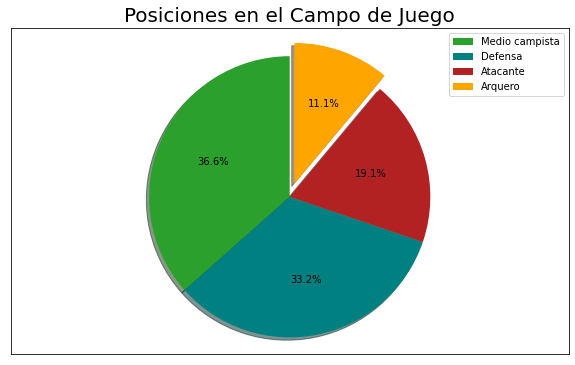

In [10]:
labels  = df["Main_Position"].value_counts().index
sizes   = df["Main_Position"].value_counts().values
explode = (0,0,0,0.1)
plt.figure(figsize=(10,6))
plt.pie(x=sizes,explode=explode,autopct='%1.1f%%',shadow=True, 
        startangle=90, frame=True,colors=["tab:green","teal","firebrick","orange"])
plt.axis('equal')
plt.legend(labels)
plt.title("Posiciones en el Campo de Juego",fontsize=20)
plt.xticks([])
plt.yticks([])
plt.show()

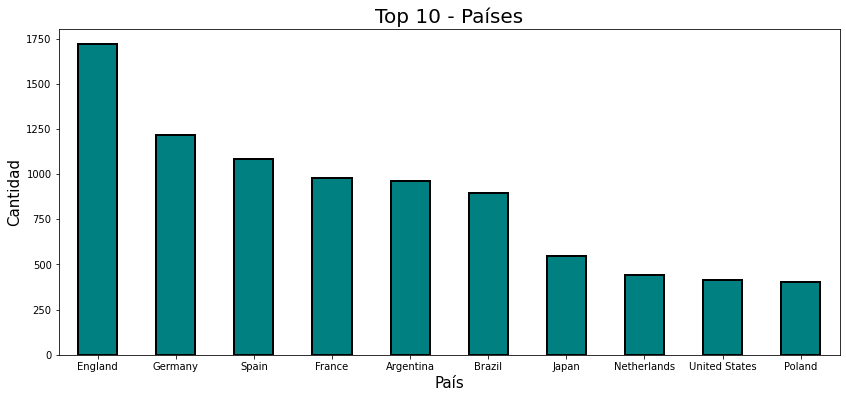

In [11]:
plt.figure(figsize=(14,6))

df["nationality_name"].value_counts()[:10].plot(kind="bar",color="teal",lw=2,edgecolor="black")
plt.xticks(rotation=0)
plt.xlabel("País",fontsize=15)
plt.ylabel("Cantidad",fontsize=15)
plt.title("Top 10 - Países",fontsize=20)
plt.show()

- De la Base de datos la mayoría son medio campistas y el país con mayor presencia de jugadores es Inglaterra.

### Seleccionamos las variables por tipo
    1 - Objeto 
    2- Numericas



In [12]:
# tipo objeto:
s = df.select_dtypes(include = ['object'])
print(len(s.columns), 'variables')
print(f'variables texto: {s.columns}')

51 variables
variables texto: Index(['player_url', 'short_name', 'long_name', 'player_positions', 'dob',
       'club_name', 'league_name', 'club_position', 'club_loaned_from',
       'club_joined', 'nationality_name', 'nation_position', 'preferred_foot',
       'work_rate', 'body_type', 'real_face', 'player_tags', 'player_traits',
       'ls', 'st', 'rs', 'lw', 'lf', 'cf', 'rf', 'rw', 'lam', 'cam', 'ram',
       'lm', 'lcm', 'cm', 'rcm', 'rm', 'lwb', 'ldm', 'cdm', 'rdm', 'rwb', 'lb',
       'lcb', 'cb', 'rcb', 'rb', 'gk', 'player_face_url', 'club_logo_url',
       'club_flag_url', 'nation_logo_url', 'nation_flag_url', 'Main_Position'],
      dtype='object')


In [13]:
# Tipo numericas - habilidades:
h_num = df.select_dtypes(include = np.number, exclude = float)
print(len(h_num.columns), 'variables')
print(f'variables numericas: {h_num.columns}')


44 variables
variables numericas: Index(['sofifa_id', 'overall', 'potential', 'age', 'height_cm', 'weight_kg',
       'nationality_id', 'weak_foot', 'skill_moves',
       'international_reputation', 'attacking_crossing', 'attacking_finishing',
       'attacking_heading_accuracy', 'attacking_short_passing',
       'attacking_volleys', 'skill_dribbling', 'skill_curve',
       'skill_fk_accuracy', 'skill_long_passing', 'skill_ball_control',
       'movement_acceleration', 'movement_sprint_speed', 'movement_agility',
       'movement_reactions', 'movement_balance', 'power_shot_power',
       'power_jumping', 'power_stamina', 'power_strength', 'power_long_shots',
       'mentality_aggression', 'mentality_interceptions',
       'mentality_positioning', 'mentality_vision', 'mentality_penalties',
       'mentality_composure', 'defending_marking_awareness',
       'defending_standing_tackle', 'defending_sliding_tackle',
       'goalkeeping_diving', 'goalkeeping_handling', 'goalkeeping_kicking',

# Limpieza de la Base de datos para aplicar las técnicas de Clustering:

- Retiramos jugadores con bajo Desempeño global ("Overall") y consideramos Variables de desempeño por habilidad (skills_ratings)

In [14]:
df2= pd.DataFrame()
df2[['short_name','Main_Position']]=s[['short_name','Main_Position']]
skills_ratings = ['overall','skill_moves',
                  'attacking_crossing', 'attacking_finishing',
                  'attacking_heading_accuracy', 'attacking_short_passing',
                  'attacking_volleys', 'skill_dribbling', 'skill_curve',
                  'skill_fk_accuracy', 'skill_long_passing', 'skill_ball_control',
                  'movement_acceleration', 'movement_sprint_speed', 'movement_agility',
                  'movement_reactions', 'movement_balance', 'power_shot_power',
                  'power_jumping', 'power_stamina', 'power_strength', 'power_long_shots',
                  'mentality_aggression', 'mentality_interceptions',
                  'mentality_positioning', 'mentality_vision', 'mentality_penalties',
                  'mentality_composure', 'defending_marking_awareness',
                  'defending_standing_tackle', 'defending_sliding_tackle',
                  'goalkeeping_diving', 'goalkeeping_handling', 'goalkeeping_kicking',
                  'goalkeeping_positioning', 'goalkeeping_reflexes'
                 ]
df2[skills_ratings]=h_num[skills_ratings]



In [15]:
df2=df2[(df2['overall']>70)].loc[:10000] # los primeros jugadores que superen el overall 70

In [16]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4593 entries, 0 to 4592
Data columns (total 38 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   short_name                   4593 non-null   object
 1   Main_Position                4593 non-null   object
 2   overall                      4593 non-null   int64 
 3   skill_moves                  4593 non-null   int64 
 4   attacking_crossing           4593 non-null   int64 
 5   attacking_finishing          4593 non-null   int64 
 6   attacking_heading_accuracy   4593 non-null   int64 
 7   attacking_short_passing      4593 non-null   int64 
 8   attacking_volleys            4593 non-null   int64 
 9   skill_dribbling              4593 non-null   int64 
 10  skill_curve                  4593 non-null   int64 
 11  skill_fk_accuracy            4593 non-null   int64 
 12  skill_long_passing           4593 non-null   int64 
 13  skill_ball_control           4593

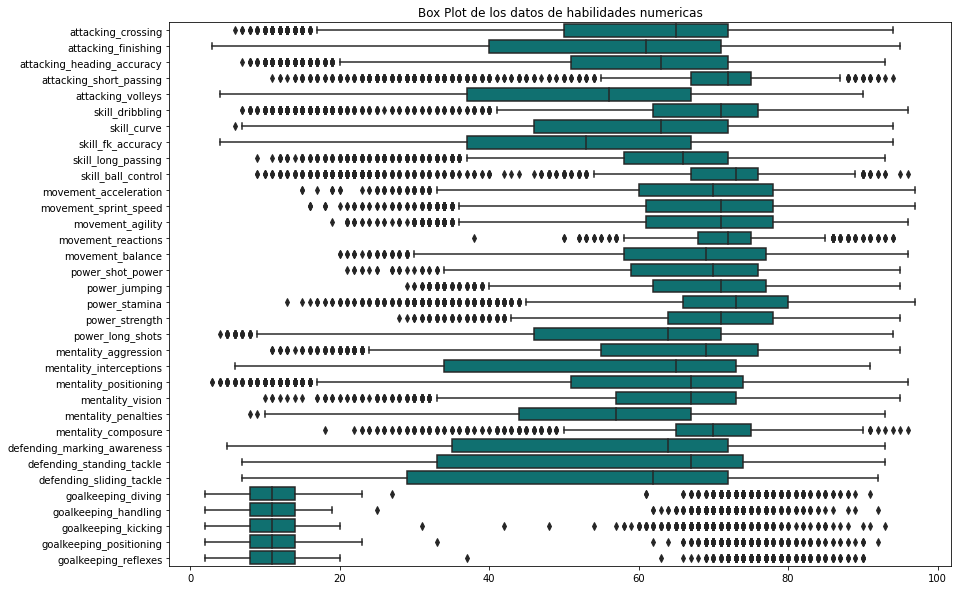

In [17]:
plt.figure(figsize=(14,10))
sns.boxplot(data=df2.iloc[:,4:], orient="h", palette=["teal"])
plt.title("Box Plot de los datos de habilidades numericas")
plt.show()

In [32]:
bool_crack=df2["overall"] > 85 # mejores jugadores
skill_1= 'power_strength'
skill_2= 'mentality_penalties'

graf1=go.Scatter(x=df2[skill_1], y=df2[skill_2],
                   mode='markers',text=df.loc[:,'club_name'], 
                   marker=dict(size=5))

crack=go.Scatter(x=df2.loc[bool_crack,skill_1], y=df2.loc[bool_crack,skill_2],
                 name='Top players',text=df2.loc[bool_crack,'short_name'],
                 textfont=dict(family='sans serif',size=10,color='black'),
                 opacity=0.9,mode='text')
data=[graf1,crack]

layout = go.Layout(title="Visualización de power_strength vs mentality_penalties",
                   titlefont=dict(size=20),xaxis=dict(title=skill_1),yaxis=dict(title=skill_2),
                   autosize=False, width=700,height=700)
fig = go.Figure(data=data, layout=layout)

#En Colab
fig.show(renderer="colab")

Energía (Stamina): Determina que tanto se cansa un jugador, cuanto mayor sea esta stats podrá finalizar todo el partido sin problemas. Los jugadores cansados ven reducidas sus stats de Aceleración, Agilidad, Salto, Fuerza, Reacción y Marcaje.
Fuerza (Strength): Determina la probabilidad de que un jugador tenga éxito en un desafío físico.

## 3.-Exploratorio-Visual-para-Clustering

Gráfica con Plotly, más completa e interactiva pero un poco pesada

In [ ]:
#En Jupyter Ntb abre en otra ventana, 
plot(fig)

'temp-plot.html'

**Consigna de trabajo:** buscar agrupamientos de jugadores de manera intuitiva por cercanía (en espacios bidimensionales, de a dos variables por vez).

Que siginifica cercanía? cómo se mide? en que espacio/s están buscando? 

Si se encuentran, tratar de explicarlos visualmente.

-----------------------------------------------------
En próxima gráfica, similar a la anterior, también se diferencian los mejores jugadores y alguna característica/variable de interés (que pueden cambiar)

Se puede ubicar también un jugador en particular. Con la siguiente linea de comando, por ejemplo, Leo Messi: 

Gráfica con plotly

**Identifiquemos algunos jugadores por nombre**